# General Experiment.
Modular setup of the AL experiments

## libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import laplace
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet, ConvNet
from main.training_models import test_performance
from main.utils import save_experiment, load_experiment
from laplace.curvature import AsdlGGN, AsdlGGN
from main.laplace_batch import get_laplace_batch


%reload_ext autoreload
%autoreload 2

c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and experiment parameters

In [2]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters

## Active learning parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 5 # Number of samples to acquire in each acquisition step

## Training parameters
test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 64  # Batch size for scoring 
training_iterations_nn = 4096 * 6 # Number of training iterations (batches) to run
training_iterations_la = 4096 * 6  # Number of training iterations (batches) to run

## Model parameters
hessian_structure = "kron"  # Options: "full", "kron", "lowrank" and "diag"
subset_of_weights = "last_layer"  # Options: "all", "subnetwork" and "last_layer"
backend = AsdlGGN  # Options: CurvlinopsGGN, CurvlinopsEF, AsdlEF, AsdlGGN, BackPackGGN
al_method = 'max_logdet_S'  # Options: "logit_entropy", "probit_entropy", "entropy", "bald"
temperature = 1  # Temperature for LA model

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


In [3]:
train_loader_benchmark = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                     sampler=torch.utils.data.SubsetRandomSampler(range(max_training_samples)))
accs = test_performance(ConvNet, train_loader_benchmark, test_loader, repeats=10)
print(f"Initial performance: {torch.mean(accs):.3f} +- {torch.std(accs):.3f}")

Epoch 1/40, Loss: 2.2790260314941406
Epoch 6/40, Loss: 1.4461164474487305
Epoch 11/40, Loss: 0.47085005044937134
Epoch 16/40, Loss: 0.16333997249603271
Epoch 21/40, Loss: 0.03856278955936432
Epoch 26/40, Loss: 0.024504441767930984
Epoch 31/40, Loss: 0.005573248490691185
Epoch 36/40, Loss: 0.004476090893149376
Accuracy of the network on the test data: 76.48%
Epoch 1/40, Loss: 2.2760512828826904
Epoch 6/40, Loss: 1.2796940803527832
Epoch 11/40, Loss: 0.43450281023979187
Epoch 16/40, Loss: 0.11711275577545166
Epoch 21/40, Loss: 0.06586829572916031
Epoch 26/40, Loss: 0.018535656854510307
Epoch 31/40, Loss: 0.007437944412231445
Epoch 36/40, Loss: 0.004991069436073303
Accuracy of the network on the test data: 75.64%
Epoch 1/40, Loss: 2.2653181552886963
Epoch 6/40, Loss: 1.5990852117538452
Epoch 11/40, Loss: 0.7037209272384644
Epoch 16/40, Loss: 0.18051743507385254
Epoch 21/40, Loss: 0.02560562826693058
Epoch 26/40, Loss: 0.01870080456137657
Epoch 31/40, Loss: 0.005936708301305771
Epoch 36/40

KeyboardInterrupt: 

## Running Experiment

In [4]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []
added_labels = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = ConvNet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader_nn, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = F.log_softmax(model(data).squeeze(1), dim=1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = model(data).squeeze(1)
            loss += loss_fn(prediction, target)

            prediction = prediction.argmax(dim=1)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire new batch from pool samples using entropy acquisition function
    N = len(active_learning_data.pool_dataset)
    
    la = laplace.Laplace(
                        model,
                        likelihood="classification",
                        subset_of_weights=subset_of_weights,
                        hessian_structure=hessian_structure,
                        backend=backend,
                        temperature=temperature/len(active_learning_data.training_dataset),
                     )
    
    print('Fitting Laplace')
    la.fit(train_loader_la, progress_bar=True)

    print('Optimizing prior precision')
    la.optimize_prior_precision(method='marglik', verbose=True, pred_type='glm', link_approx='probit')
    
    candidate_batch = get_laplace_batch(model=la, pool_loader=pool_loader,
                                            acquisition_batch_size=acquisition_batch_size,
                                            device=device, 
                                            method=al_method)


    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    added_labels.append(targets[candidate_batch.indices])
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [00:00<?, ?it/s]

Test set: Average loss: -0.0176, Accuracy: 7304/10000 (73.04%)
Fitting Laplace


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\laplace\baselaplace.py:409: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


Optimizing prior precision
Optimized prior precision is tensor([60.5140]).


Training Set Size:  45%|████▌     | 45/100 [01:24<15:26, 16.84s/it]

Dataset indices:  [ 7579 32980 58633 10859 21595]
Scores:  [0.0, 0.0, 0.0, 0.0, 0.0]
Labels:  tensor([4, 7, 5, 0, 9])


Test set: Average loss: -0.0169, Accuracy: 7386/10000 (73.86%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([57.3871]).


Training Set Size:  50%|█████     | 50/100 [02:39<13:07, 15.76s/it]

Dataset indices:  [27885 12798 58024 50620 30696]
Scores:  [0.0, 0.0, 0.0, 0.0, 0.0]
Labels:  tensor([1, 1, 8, 7, 9])


Test set: Average loss: -0.0250, Accuracy: 7413/10000 (74.13%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([61.4044]).


Training Set Size:  55%|█████▌    | 55/100 [03:54<11:34, 15.43s/it]

Dataset indices:  [23705 50510 49065 54920 57443]
Scores:  [0.0, 0.0, 0.0, 0.0, 0.0]
Labels:  tensor([2, 4, 0, 8, 4])


KeyboardInterrupt: 

## Storing results

In [ ]:
experiment_id = np.random.randint(1000, 9999)

In [ ]:
params_dict = {
    'num_initial_samples': num_initial_samples,
    'num_classes': num_classes,
    'max_training_samples': max_training_samples,
    'acquisition_batch_size': acquisition_batch_size,
    'test_batch_size': test_batch_size,
    'batch_size': batch_size,
    'scoring_batch_size': scoring_batch_size,
    'training_iterations_nn': training_iterations_nn,
    'training_iterations_la': training_iterations_la,
}

# generate a unique experiment id of 3 digits (just to make sure don't override things, clean up later)
save_experiment(f'{al_method}_{hessian_structure}_{subset_of_weights}_K{acquisition_batch_size}_{experiment_id}',
                params_dict, {
    'test_accs': test_accs,
    'test_loss': test_loss,
    'added_indices': added_indices
})

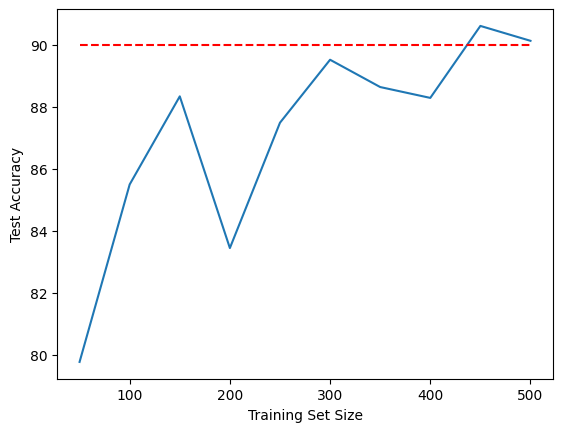

In [ ]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')
plt.savefig(f'plots/{al_method}_{hessian_structure}_{subset_of_weights}_K{acquisition_batch_size}_{experiment_id}.png')
plt.show()